In [18]:
# https://github.com/pytorch/examples/blob/master/vae/main.py
from fastai.vision import *
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision as ptv

import pandas as pd
import numpy as np
from utils.clr import *
from utils.blocks import *

#one use
from datetime import date
import pandas as pd

In [19]:
use_cuda = torch.cuda.is_available(); print(use_cuda)
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
CUDA_LAUNCH_BLOCKING=1
%matplotlib inline
%reload_ext autoreload
%autoreload 2

True


In [32]:
bs = 30
sz=28
epochs = 3

In [33]:
PATH = Path("../data/mnist")
train = MNIST(PATH, train=True, transform=ptv.transforms.ToTensor())
val = MNIST(PATH, train=False, transform=ptv.transforms.ToTensor())

trn_dl = DataLoader(train, batch_size=bs)
val_dl = DataLoader(val, batch_size=bs)

In [22]:
def append_stats(ep_vals, epoch, values, decimals=6):
    ep_vals[epoch]=list(np.round(values, decimals))
    return ep_vals

def print_stats(epoch, values, decimals=3):
    layout = "{!s:^10}" + " {!s:10}" * len(values)
    values = [epoch] + list(np.round(values, decimals))
    print(layout.format(*values))

def save_checkpoint(name, filename, is_best):
    save_name = f'../data/checks/{filename}'
    state = {'epoch': epochs,
            'last_epoch': epoch,
            'arch': filename,
            'state_dict': net.state_dict(),
            'losses': [t_ls,v_ls],
            'optimizer': optim.state_dict(),
            'scheduler': scheduler.__dict__}

    torch.save(state, save_name)
    if is_best:
        val_date = date.today()
        torch.save(sate,save_name + f'best_{val_date}')
    print('Checkpoint saved.')

def vae_loss(pred, targ, mean, logvar):
    kl = -0.2 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    recon = loss(pred, targ)
    return kl + recon
    
names = ["ep / it","trn_loss", 'recon_loss','kl_loss',"val_loss"]
# names = ["ep / it", "trn_loss","lwst_trn","val_loss","accuracy"]
layout = "{!s:10} " * len(names)

window = 200

cols = names[1:]

In [23]:
class VAE(nn.Module):
    def __init__(self,n_node,n_z,p):
        super(VAE,self).__init__()
        self.name = f"LinVAE-{n_lat}x{lat_chan}"
        self.n_node = n_node
        self.n_z = n_z
        self.p = p
        
        self.full1 = nn.Linear(sz**2,n_node)
        self.drop1 = nn.Dropout(p=p)
        self.full12 = nn.Linear(n_node,n_node//2)
        
        self.fullStd = nn.Linear(n_node//2,n_z)
        self.fullMean = nn.Linear(n_node//2,n_z)
        
        self.full2 = nn.Linear(n_z,n_node)
        self.drop2 = nn.Dropout(p=p)
        self.fullOut = nn.Linear(n_node,sz**2)
        
    def encode(self,x):
        h1 = F.relu(self.drop1(self.full1(x)))
        h1 = F.relu(self.full12(h1))
        return self.fullStd(h1), self.fullMean(h1)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def decode(self,z):
        h3 = F.relu(self.drop2(self.full2(z)))
        return torch.sigmoid(self.fullOut(h3))
    
    def forward(self,x):
        mu, logvar = self.encode(x.view(-1,sz**2))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), (mu, logvar)
    
stat_table = []

In [24]:
class DenseLinVAE(nn.Module):
    def __init__(self,n_node,n_z,p):
        super(DenseLinVAE,self).__init__()
        self.name = f"DenseLinVAE-{n_lat}x{lat_chan}"
        self.n_node = n_node
        self.n_z = n_z
        self.p = p
        
        self.full1 = nn.Linear(sz**2,n_node)
        self.drop1 = nn.Dropout(p=p)
        self.full12 = DenseLinBlock(n_node,n_node//2)
        
        self.fullStd = nn.Linear(n_node//2,n_z)
        self.fullMean = nn.Linear(n_node//2,n_z)
        
        self.full2 = DenseLinBlock(n_z,n_node)
        self.drop2 = nn.Dropout(p=p)
        self.fullOut = nn.Linear(n_node,sz**2)
        
    def encode(self,x):
        h1 = F.relu(self.drop1(self.full1(x)))
        h1 = F.relu(self.full12(h1))
        return self.fullStd(h1), self.fullMean(h1)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def decode(self,z):
        h3 = F.relu(self.drop2(self.full2(z)))
        return torch.sigmoid(self.fullOut(h3))
    
    def forward(self,x):
        mu, logvar = self.encode(x.view(-1,sz**2))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), (mu, logvar)
    
stat_table = []

In [25]:
class ShuntDenseLinVAE(nn.Module):
    def __init__(self,n_node,n_z,p):
        super(ShuntDenseLinVAE,self).__init__()
        self.name = f"ShuntDenseLinVAE-{n_lat}x{lat_chan}"
        self.n_node = n_node
        self.n_z = n_z
        self.p = p
        
        self.full1 = nn.Linear(sz**2,n_node)
        self.drop1 = nn.Dropout(p=p)
        self.full12 = DenseLinBlock(n_node,n_node//2)
        self.full13 = nn.Linear(n_node//2,n_node//2)
        
        self.fullStd = nn.Linear(n_node//2,n_z)
        self.fullMean = nn.Linear(n_node//2,n_z)
        
        self.full21 = nn.Linear(n_z,n_node//2)
        self.full22 = DenseLinBlock(n_node//2,n_node)
        self.drop2 = nn.Dropout(p=p)
        self.fullOut = nn.Linear(n_node,sz**2)
        
    def encode(self,x):
        h1 = F.relu(self.drop1(self.full1(x)))
        h1 = F.relu(self.full12(h1))
        h1 = F.relu(self.full13(h1))
        return self.fullStd(h1), self.fullMean(h1)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def decode(self,z):
        h3 = F.relu(self.full21(z))
        h3 = F.relu(self.drop2(self.full22(h3)))
        return torch.sigmoid(self.fullOut(h3))
    
    def forward(self,x):
        mu, logvar = self.encode(x.view(-1,sz**2))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), (mu, logvar)
    
stat_table = []

In [26]:
class BowDenseLinVAE(nn.Module):
    def __init__(self,n_node,n_z,p):
        super(BowDenseLinVAE,self).__init__()
        self.name = f"BowDenseLinVAE-{n_lat}x{lat_chan}"
        self.n_node = n_node
        self.n_z = n_z
        self.p = p
        
        self.full1 = nn.Linear(sz**2,n_node)
        self.drop1 = nn.Dropout(p=p)
        self.full12 = DenseLinBlock(n_node,n_node//2)
        self.full13 = nn.Linear(n_node//2,n_node//2**2)
        
        self.fullStd = nn.Linear(n_node//2**2,n_z)
        self.fullMean = nn.Linear(n_node//2**2,n_z)
        
        self.full21 = nn.Linear(n_z,n_node//2)
        self.full22 = DenseLinBlock(n_node//2,n_node)
        self.drop2 = nn.Dropout(p=p)
        self.fullOut = nn.Linear(n_node,sz**2)
        
    def encode(self,x):
        h1 = F.relu(self.drop1(self.full1(x)))
        h1 = F.relu(self.full12(h1))
        h1 = F.relu(self.full13(h1))
        return self.fullStd(h1), self.fullMean(h1)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def decode(self,z):
        h3 = F.relu(self.full21(z))
        h3 = F.relu(self.drop2(self.full22(h3)))
        return torch.sigmoid(self.fullOut(h3))
    
    def forward(self,x):
        mu, logvar = self.encode(x.view(-1,sz**2))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), (mu, logvar)
    
stat_table = []

In [27]:
g = iter(val_dl)

In [28]:
# def generate(bs=bs,mode=None):
# #     vx = torch.FloatTensor([np.random.normal(0, 1, sz**2) for _ in range(bs)]).cuda()
# #     vx = torch.FloatTensor([np.random.normal(0,7,7) for _ in range(bs)]).cuda()
#     vx = torch.FloatTensor([np.random.normal(0, 1, 1024) for _ in range(bs)]).cuda()
#     vx = vx.view(-1,1,32,32)
#     net = nets[2][1].eval()
# #         vx = Variable(torch.randn(bs,params["sz"]**2,dtype=torch.float, device="cuda")).view(-1,1,params["sz"],params["sz"])
#     return net(vx)

def display_recon(g=iter(val_dl),bs=8):
    x, _ = next(g)
    x = x.type(dtype)
    vx = x[:bs]
    z_im, _= net(vx)
    z_im = z_im.data.cpu().numpy().reshape(-1,28,28)*255.
    fig, axes = plt.subplots(2, bs, figsize=(15,3))
    for ax, im in enumerate(x[:bs]):
        axes[0,ax].imshow(im[0,:,:])
        axes[1,ax].imshow(z_im[ax])
    plt.tight_layout()
    
# def display_gen(bs=16, mode=0):
#     if mode == 0:
#         ims,_ = generate(bs, mode)
#     else:
#         ims = generate(bs, mode)
#     ims = ims.data.cpu().numpy()
#     ims = ims.reshape(-1,28,28)*255.
#     plt.figure(figsize=(15,3))
#     for i, im in enumerate(ims):
#         plt.subplot(2,bs/2,i+1)
#         plt.imshow(im)
#     plt.tight_layout()

In [34]:
chans = [(300,10),(200,10)]
p= .3
nets=[]
for n_lat, lat_chan in chans:
#     net1 = DenseLinVAE(n_lat,lat_chan,p)
#     net2 = ShuntDenseLinVAE(n_lat,lat_chan,p)
    net3 = BowDenseLinVAE(n_lat,lat_chan,p)
#     nets.append((net1.name,net1))
#     nets.append((net2.name,net2))
    nets.append((net3.name,net3))

In [35]:
if use_cuda:
    [net.to("cuda") for _,net in nets]
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor
    
lr = 1.3e-4

optims = [torch.optim.Adam(net.parameters(), lr=lr) for _,net in nets]
loss = nn.BCELoss(reduction="sum")
schedulers = [CyclicLR(optim, lr, mode='triangular2', step_size=len(train)//2) for optim in optims]

BowDenseLinVAE-300x10
ep / it    trn_loss   recon_loss kl_loss    val_loss   
  1 / 1    16314.418  16313.958  0.3831     16294.9912


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([30, 1, 28, 28])) that is different to the input size (torch.Size([30, 784])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


 1 / 201   8491.2588  8452.5795  32.2327    5983.0469 
 1 / 401   6333.2108  6311.4131  18.1648    6153.6748 
 1 / 601   6166.5209  6129.1835  31.1144    5382.7158 
 1 / 801   5974.9318  5918.5594  46.977     5511.0723 
 1 / 1001  5684.1346  5627.5632  47.1428    5267.9561 
 1 / 1201  5652.3275  5602.6614  41.3884    5047.1777 
 1 / 1401  5645.1215  5591.6528  44.5572    5098.7935 
 1 / 1601  5472.4607  5396.4424  63.3486    5083.2222 
 1 / 1801  5213.595   5113.085   83.7583    4839.6123 
Checkpoint saved.
  2 / 1    4992.7294  4880.3379  93.6596    4834.5649 
 2 / 201   4816.3422  4695.826   100.4302   4617.5312 
 2 / 401   4676.3764  4557.7115  98.8875    4598.3735 
 2 / 601   4691.6887  4571.2157  100.3941   4296.3301 
 2 / 801   4598.044   4475.9256  101.7653   4382.7158 
 2 / 1001  4499.8439  4376.4059  102.8651   4297.1543 
 2 / 1201  4448.6484  4323.2168  104.5263   3855.5957 
 2 / 1401  4497.2227  4371.529   104.7447   4189.8281 
 2 / 1601  4443.0353  4315.896   105.9494   422

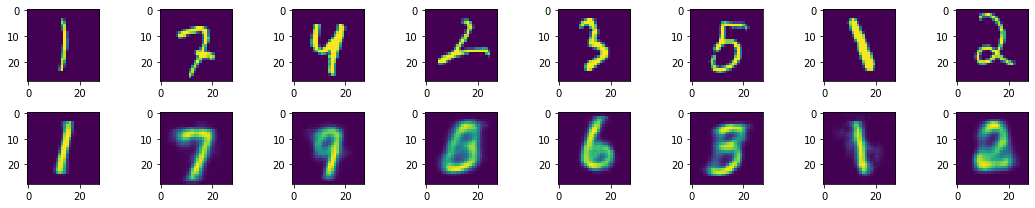

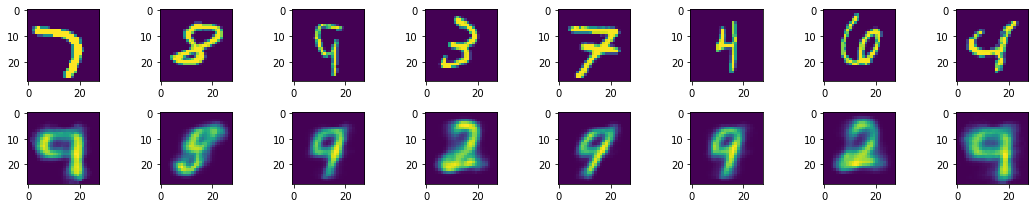

In [36]:
for i,(name,net) in enumerate(nets):
    t_ls = []
    r_ls = []
    k_ls = []
    v_ls = []
    accs = []
    ep_vals = OrderedDict()
    optim = optims[i]
    scheduler = schedulers[i]
    print(name)
    for epoch in range(epochs):
        if epoch == 0: print(layout.format(*names))
        val_it = iter(val_dl)
        for i, (batch, ys) in enumerate(trn_dl, 0):
            scheduler.batch_step()        
            batch = batch.type(dtype)
            ys = ys.type(dtype)
            
            net.train()
            
            pred, (mean, logvar) = net(batch)
            
            kl = -0.2 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
            recon = loss(pred, batch)
            ls = kl*1.2 + recon
            
            t_ls.append(ls.item())
            r_ls.append(recon.item())
            k_ls.append(kl.item())
            
            optim.zero_grad()
            ls.backward()
            optim.step()
            vals = [np.mean(t_ls[-window:]), np.mean(r_ls[-window:]), np.mean(k_ls[-window:])]

            if i % window == 0:
                net.eval()
                
                with torch.no_grad():
                    v_bat, v_ys = next(val_it)

                    v_bat = v_bat.type(dtype)
                    v_ys = v_ys.type(dtype)
                    
                    v,( mean, logvar) = net(v_bat)
                    
                    v_loss = vae_loss(v, v_bat, mean, logvar)
                    v_ls.append(v_loss.item())
                vals.append(v_loss.item())
                print_stats(f"{epoch+1} / {i+1}",vals,4)
                stat_table.append([name,epoch+1, i+1,*vals])
        save_checkpoint('vae_tut', name, False)
        ep_vals = append_stats(ep_vals, epoch+1, vals)
    display_recon() #; display_gen()

In [95]:
str_idx = (cols[:3] for cols in stat_table)
idx = pd.MultiIndex.from_tuples(str_idx,names=['Model','Epoch','Iteration'])
sub_table = [sublist[3:] for sublist in stat_table]

df_stats = pd.DataFrame(sub_table,columns=cols,index=idx)
df_stats.loc[(slice(None),epochs,3601),:]

UnsortedIndexError: 'MultiIndex slicing requires the index to be lexsorted: slicing on levels [2], lexsort depth 0'

In [278]:
str_idx = (cols[:3] for cols in stat_table)
idx = pd.MultiIndex.from_tuples(str_idx,names=['Model','Epoch','Iteration'])
sub_table = [sublist[3:] for sublist in stat_table]

df_stats = pd.DataFrame(sub_table,columns=cols,index=idx)
df_stats.loc[('VAE-200x10',3,3601),:]

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/core/indexing.py:1494: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


trn_loss   recon_loss     kl_loss     val_loss
Model      Epoch Iteration                                                   
VAE-200x10 3     3601       2044.523618  1890.257640  128.554975  1987.336548
                 3601       2187.475117  2038.570497  124.087181  2120.029785